# Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
# from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd
import cv2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm

def set_seed(seed=0): # 모든 시드값 고정 (학습을 위해)
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    
set_seed(22)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device를 cuda로 설정
print(device)

cuda


# Dataset 준비하기

In [3]:
# train과 test csv 파일 가져오기
train_dataframe = pd.read_csv('./data.csv')
test_df = pd.read_csv('./testdata.csv')

In [4]:
train_dataframe.head()

,Image,Label,Age,Gender,Race
0,10_0_0_20170103200329407.jpg,0,10,0,0
1,10_0_0_20170103200522151.jpg,0,10,0,0
2,10_0_0_20170103233459275.jpg,0,10,0,0
3,10_0_0_20170110220251986.jpg,0,10,0,0
4,10_0_0_20170110220255346.jpg,0,10,0,0


In [7]:
test_df.head()

,Image,Gender,Race
0,0_0_20170110220546177.jpg,0,0
1,0_0_20170110225451638.jpg,0,0
2,0_4_20170103200409638.jpg,0,4
3,0_0_20161219154556757.jpg,0,0
4,0_0_20161219154956869.jpg,0,0


### 데이터 분석

In [5]:
print('남자 : ', len(train_dataframe[train_dataframe['Gender']==0]))
print('여자 : ', len(train_dataframe[train_dataframe['Gender']==1]))
print('백인 : ', len(train_dataframe[train_dataframe['Race']==0]))
print('백인 중 남자 : ', len(train_dataframe[(train_dataframe['Race']==0) & (train_dataframe['Gender']==0)]))
print('백인 중 여자 : ', len(train_dataframe[(train_dataframe['Race']==0) & (train_dataframe['Gender']==1)]))

print('흑인 : ', len(train_dataframe[train_dataframe['Race']==1]))
print('흑인 중 남자 : ', len(train_dataframe[(train_dataframe['Race']==1) & (train_dataframe['Gender']==0)]))
print('흑인 중 여자 : ', len(train_dataframe[(train_dataframe['Race']==1) & (train_dataframe['Gender']==1)]))

print('아시아인 : ', len(train_dataframe[train_dataframe['Race']==2]))
print('아시아인 중 남자 : ', len(train_dataframe[(train_dataframe['Race']==2) & (train_dataframe['Gender']==0)]))
print('아시아인 중 여자 : ', len(train_dataframe[(train_dataframe['Race']==2) & (train_dataframe['Gender']==1)]))

print('동남아인 : ', len(train_dataframe[train_dataframe['Race']==3]))
print('동남아인 중 남자 : ', len(train_dataframe[(train_dataframe['Race']==3) & (train_dataframe['Gender']==0)]))
print('동남아인 중 여자 : ', len(train_dataframe[(train_dataframe['Race']==3) & (train_dataframe['Gender']==1)]))

print('그외... : ', len(train_dataframe[train_dataframe['Race']==4]))
print('그외 중 남자 : ', len(train_dataframe[(train_dataframe['Race']==4) & (train_dataframe['Gender']==0)]))
print('그외 중 여자 : ', len(train_dataframe[(train_dataframe['Race']==4) & (train_dataframe['Gender']==1)]))

남자 :  3766
여자 :  3574
백인 :  3065
백인 중 남자 :  1600
백인 중 여자 :  1465
흑인 :  1363
흑인 중 남자 :  682
흑인 중 여자 :  681
아시아인 :  1036
아시아인 중 남자 :  504
아시아인 중 여자 :  532
동남아인 :  1236
동남아인 중 남자 :  699
동남아인 중 여자 :  537
그외... :  640
그외 중 남자 :  281
그외 중 여자 :  359


In [6]:
print('test중 남자 : ', len(test_df[test_df['Gender']==0]))
print('test중 여자 : ', len(test_df[test_df['Gender']==0]))
print('test중 백인 : ', len(test_df[test_df['Race']==0]))
print('test중 흑인 : ', len(test_df[test_df['Race']==1]))
print('test중 아시아인 : ', len(test_df[test_df['Race']==2]))
print('test중 동남아인 : ', len(test_df[test_df['Race']==3]))
print('test중 그외... : ', len(test_df[test_df['Race']==4]))

test중 남자 :  421
test중 여자 :  421
test중 백인 :  364
test중 흑인 :  138
test중 아시아인 :  120
test중 동남아인 :  141
test중 그외... :  59


In [8]:
# from sklearn.model_selection import train_test_split

train_df = train_dataframe

In [9]:
# from sklearn.model_selection import train_test_split

# train_df, valid_df = train_test_split(train_dataframe, shuffle=True, test_size=0.01, stratify=train_dataframe['Label'])

In [10]:
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self, dataframe, train='train', transform=None):
        if train == 'train': # train일 때 실행
            self.image_list = []
            self.label_list = []
            self.other_list = []
            path = './dataset/{}/{}' # 이미지의 경로를 가져오기 위해 공통 경로 설정
            for index, row in dataframe.iterrows(): # dataframe으로 부터 읽어옴
                # 이미지, label, meta data 값들 가져와서 저장
                image_path = row['Image'] 
                image_label = row['Label']
                image_age = row['Age']
                image_gender = row['Gender']
                image_race = row['Race']
                image = Image.open(path.format(image_label, image_path)).convert('RGB') # 위에서 선언한 path에 추가 경로 넣어 이미지 가져오기
                image = np.array(image) # 이미지 형변환
                image = transform(image=image)['image'] # augmentation 기법 적용

                # 각 데이터 list에 추가해줌
                self.image_list.append(image)
                self.label_list.append(image_label)
                self.other_list.append((image_age, image_gender, image_race))
                

        elif train == 'test': # test일 때 실행
            self.image_list = []
            self.label_list = []
            self.other_list = []
            path = './testset/{}' # 이미지의 경로를 가져오기 위해 공통 경로 설정
            for index, row in dataframe.iterrows(): # 이미지의 경로를 가져오기 위해 공통 경로 설정
                # 이미지, meta data 값들 가져와서 저장
                image_path = row['Image']
                image_gender = row['Gender']
                image_race = row['Race']
                image = Image.open(path.format(image_path)).convert('RGB') # 위에서 선언한 path에 추가 경로 넣어 이미지 가져오기
                image = np.array(image) # 이미지 형변환
                image = transform(image=image)['image'] # test augmentation 기법 적용
                
                # 각 데이터 list에 추가해줌
                self.image_list.append(image)
                self.label_list.append(image_path)
                self.other_list.append((image_gender, image_race))
                
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        return self.image_list[idx], self.label_list[idx], self.other_list[idx]

In [11]:
# albumentation 라이브러리를 이용하여 전처리 적용

train_transform = A.Compose([A.Resize(224, 224), # 이미지 사이즈 변경
                                # A.CenterCrop(227, 227, p=1),
                                # A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 0.7), p=0.2),
                                # A.HorizontalFlip(p=0.5),
                                # A.Rotate(limit=20, p=0.4),
                                A.OneOf([  # 이들 중 하나 택 -> 0.5 확률로
                                    A.HorizontalFlip(p=1),
                                    A.Rotate(limit=20, p=1),
                                ], p=0.5),
                             
                                # A.OneOf([
                                #     A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=0, p=1),
                                    # A.CoarseDropout(max_holes=5, max_height=24, max_width=24, p=0.1),
                                #     A.CoarseDropout(max_holes=1, max_height=50, max_width=100, p=1),
                                    # A.HueSaturationValue(hue_shift_limit=(-10, 10), sat_shift_limit=(-10, 10), val_shift_limit=(-20, 20), p=1),
                                # ], p=0.5),
                                
                                # A.OneOf([
                                    # A.Downscale(scale_min=0.7, scale_max=0.7, interpolation=cv2.INTER_NEAREST, p=0.2),
                                #     # A.PixelDropout (dropout_prob=0.005, per_channel=False, drop_value=0, mask_drop_value=None, p=1),
                                #     # A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), p=1)
                                # ], p=0.1),
                                 # A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
                                A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]), # 정규화 진행
                                ToTensorV2(p=1.0) # 텐서로 변환
                               ])


test_transform = A.Compose([A.Resize(224, 224),
                             # A.CenterCrop(190, 190, p=1),
                                # A.Resize(224, 224, p=1),
                                # A.Normalize([153.9679, 117.6702, 100.4899], [56.0226, 50.0003, 47.5295], max_pixel_value=255),
                            A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),
                                ToTensorV2(p=1.0)
                               ])

dataset = CustomDataset(train_df, train='train', transform=train_transform)
# valid_dataset = CustomDataset(valid_df, train='train', transform=test_transform)
test_dataset = CustomDataset(test_df, train='test', transform=test_transform)

# Dataset에 대한 Data Loaders 구성

In [12]:
batch_size = 64 # 배치사이즈 설정

# train과 test dataloader 설정
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Image 확인

In [13]:
classes = ['1 ~ 10', '11 ~ 20', '21 ~ 30', '31 ~ 40', '41 ~ 50']

def imshow(img):
    MEAN = np.array([0.485 , 0.456, 0.406])
    STD = np.array([0.229, 0.224 , 0.225])
    img = img * STD[:, None, None] + MEAN[:, None, None]   # 시각화 위해 unnormalize 해주기
    plt.imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1)) # imshow 위해 형변환 하여 시각화

torch.Size([64, 3, 224, 224]) torch.Size([64])


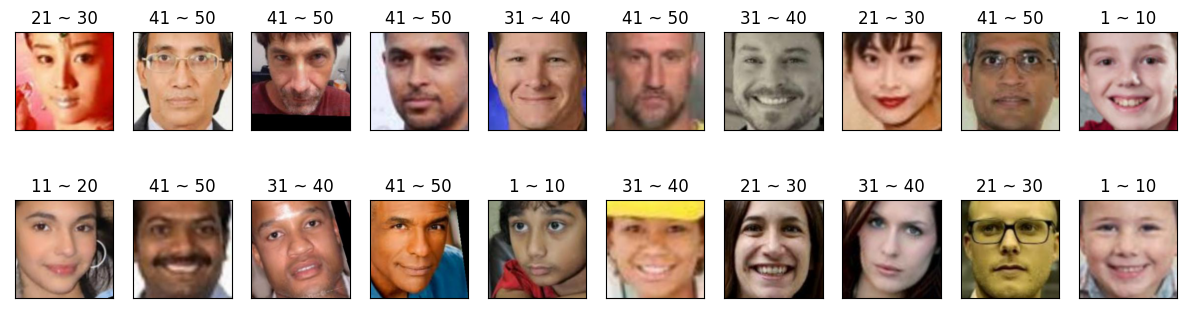

In [14]:
data, label, other =  next(iter(train_loader)) # train loader로부터 가져와 시각화
print(data.shape, label.shape)

fig = plt.figure(figsize=(15, 4))
# display 20 images
data = data.numpy()
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(data[idx])
    ax.set_title(classes[label[idx]])

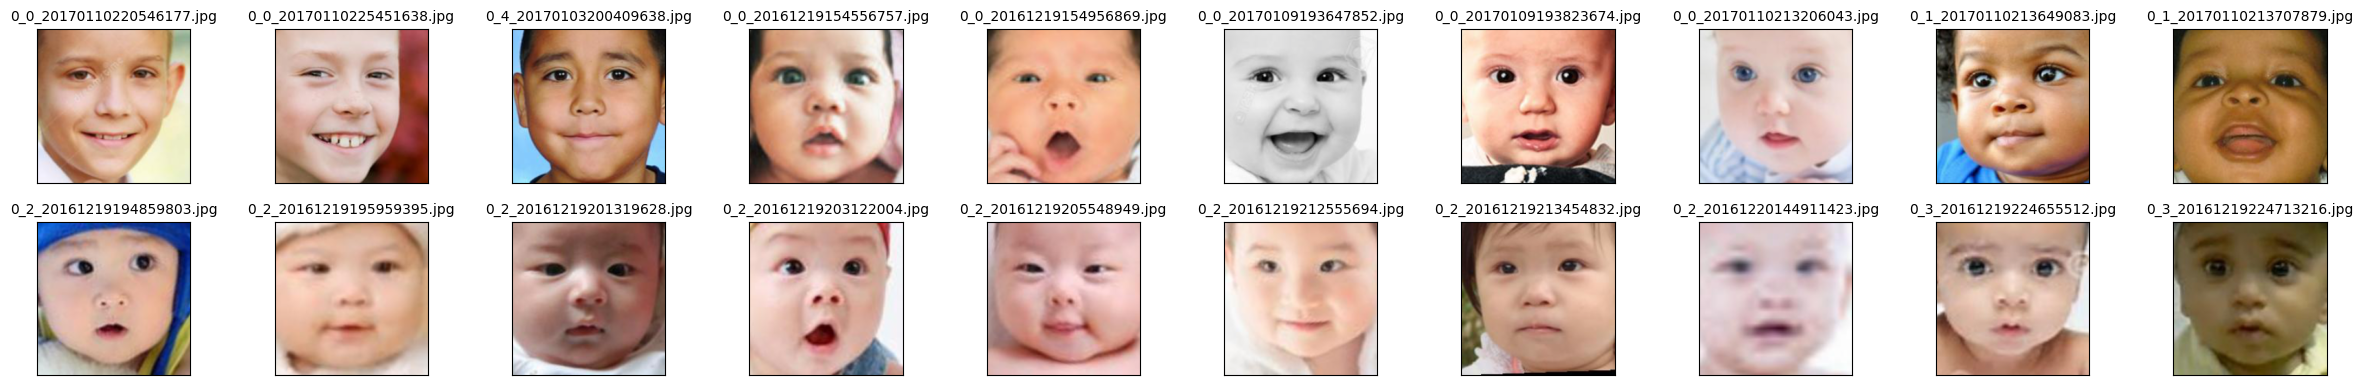

In [15]:
image, file_name, other = next(iter(test_loader))
image.shape, len(file_name)

fig = plt.figure(figsize=(25, 4))
# display 20 images
image = image.numpy()
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(image[idx])
    ax.set_title(file_name[idx], fontsize = 10)
    fig.tight_layout()

# Model 설정

In [16]:
## Main model
## 앙상블 시 사용한 모델 - model1
import torch.nn as nn

class GG2(nn.Module):
    def __init__(self, num_classes=5):
        super(GG2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max Pooling
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max Pooling
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max Pooling
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max Pooling
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max Pooling
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max Pooling
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), # Batch normalization
            nn.MaxPool2d(kernel_size=3, stride=2), # Max Pooling

        )

        self.classifier = nn.Sequential(
            nn.Linear(518, 260),
            nn.BatchNorm1d(260),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(), # dropout
            nn.Linear(260, 64),
            nn.BatchNorm1d(64),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(), # dropout
            nn.Linear(64, num_classes)
        )
        
        # Weight initialization
        self._initialize_weights()

    def forward(self, x, gender, race):
        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        gender = gender.view(gender.size(0), -1)
        race = race.view(race.size(0), -1)
        x = torch.cat((x, gender, race), dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)

In [ ]:
## 앙상블 시 사용한 모델 - model2
import torch.nn as nn

class GG2(nn.Module):
    def __init__(self, num_classes=5):
        super(GG2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )

        self.classifier = nn.Sequential(
            # nn.Linear(2054, 1024),
            # nn.BatchNorm1d(1024),  # Batch normalization
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(1030, 512),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        

        # Weight initialization

        self._initialize_weights()

    def forward(self, x, gender, race):
        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        gender = gender.view(gender.size(0), -1)
        race = race.view(race.size(0), -1)
        x = torch.cat((x, gender, race), dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)

In [ ]:
## 앙상블 시 사용한 모델 - model3
import torch.nn as nn

class GG2(nn.Module):
    def __init__(self, num_classes=5):
        super(GG2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            # nn.Linear(9222, 4096),
            # nn.BatchNorm1d(4096),  # Batch normalization
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            # nn.Linear(4096, 2048),
            # nn.BatchNorm1d(2048),  # Batch normalization
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            # nn.Linear(2048, 1024),
            # nn.BatchNorm1d(1024),  # Batch normalization
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(1030, 512),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

        # Weight initialization

        self._initialize_weights()

    def forward(self, x, gender, race):
        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        gender = gender.view(gender.size(0), -1)
        race = race.view(race.size(0), -1)
        x = torch.cat((x, gender, race), dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)

# Cost 함수 및 Optimzer 설정

In [17]:
# from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

S_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=26) # StratifiedKFold 사용 위해 선언, fold는 5로, seed 고정
k = 5
n_epochs = 50 # 에폭 50으로 학습 진행

In [1]:
def reset_weights(m): # 매 fold마다 기존의 모델에 weight 초기화
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            
# def calculate_class_weights(targets):
#     class_counts = torch.bincount(targets)
#     total_samples = targets.size(0)
#     class_weights = total_samples / (len(class_counts) * class_counts.float())
    
#     # 클래스 2와 3에 대한 가중치를 더 높게 설정
#     # class_weights[2] *= 1.5
#     class_weights[2] *= 2
#     class_weights[3] *= 2
    
#     return class_weights



# class_weights = torch.tensor([1.0, 1.0, 1.5, 1.5, 1.5]).to(device)  # 클래스마다 원하는 가중치 설정

criterion = nn.CrossEntropyLoss() # CrossEntropy 손실 함수 정의


train_losses = [] # train loss 담아 줄 리스트
valid_losses = [] # valid loss 담아 줄 리스트
train_accuracies = [] # train acc 담아 줄 리스트
valid_accuracies = [] # train acc 담아 줄 리스트

for fold, (train_index, valid_index) in enumerate(S_kfold.split(dataset, dataset.label_list)): # train dataset과 label을 사용하여 샘플링 된 데이터의 인덱스를 넘겨줌
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold+1}/{k} ...')
    
    
    train_dataframe = train_df.iloc[train_index] # 해당 인덱스의 train 데이터 값들 가져오기
    valid_dataframe = train_df.iloc[valid_index] # 해당 인덱스의 validation 데이터 값들 가져오기
    
    train_dataset = CustomDataset(train_dataframe, train='train', transform=train_transform) # 가져온 데이터로 CustomDataset 함수에 넣어주기, transform은 train 적용
    valid_dataset = CustomDataset(valid_dataframe, train='train', transform=test_transform) # 가져온 데이터로 CustomDataset 함수에 넣어주기, transform은 test 적용

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # 위에서 만든 train dataset으로 dataloader 생성, batch size
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # 위에서 만든 valid dataset으로 dataloader 생성, batch size, 검증 할 땐 shuffle=False로
    
    # 초기값 설정
    best_train_loss = np.Inf
    best_train_accuracy = 0.0
    best_valid_loss = np.Inf
    best_valid_accuracy = 0.0
    
    model = GG2() # 모델 선언
    # model = GG_ResNet()
    # model = ResNet18(5)
    # model = InceptionV2()
    # model = EfficientNetB0(num_classes=5)
    
    model.apply(reset_weights)
    model.to(device) # 모델 gpu로 
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008) # Adam optimizer 선언
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0) # CosineAnnealingLR 스케쥴러 사용
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, min_lr=1e-6)
    
    # 초기값 모두 0으로
    train_loss = torch.zeros(n_epochs)
    valid_loss = torch.zeros(n_epochs)

    train_acc = torch.zeros(n_epochs)
    valid_acc = torch.zeros(n_epochs)
    
    
    ##### train #####
    for e in range(n_epochs):
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.10f}') # 매 epoch마다 Learning Rate 출력

        model.train() # model train모드

        for data, labels, other in tqdm(train_loader):

            data, labels , gender, race = data.to(device), labels.to(device), other[1].to(device), other[2].to(device) # dataloader에서 받아온 데이터를 device로
            optimizer.zero_grad()
    
            one_hot = torch.zeros(race.size(0), 5).cuda() 
            one_hot.scatter_(1, race.unsqueeze(1), 1) # race를 onehot encoding
            
            logits = model(data, gender, one_hot) # 모델에 데이터 넣어주기
        
            loss = criterion(logits, labels) # 손실 함수를 통해 loss값 구하기
            # weighted_loss = torch.mean(class_weights[labels] * loss)
            loss.backward() # backpropagation
            optimizer.step() # parameter 업데이트
            train_loss[e] += loss.item() # train loss에 loss값 추가

            ps = F.softmax(logits, dim=1) # softmax를 통해 확률 값으로 
            # 학습 정확도 계산
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()

        train_loss[e] /= len(train_loader)
        train_acc[e] /= len(train_loader)
        
        
        ##### Validation #####
        with torch.no_grad(): 
            model.eval()
            for data, labels, other in tqdm(valid_loader):

                data, labels, gender, race = data.to(device), labels.to(device), other[1].to(device), other[2].to(device)
                    
                one_hot = torch.zeros(race.size(0), 5).cuda()
                one_hot.scatter_(1, race.unsqueeze(1), 1)

                logits = model(data, gender, one_hot)

                loss = criterion(logits, labels)

                valid_loss[e] += loss.item()

                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(top_class.shape)
                valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()

        valid_loss[e] /= len(valid_loader)
        valid_acc[e] /= len(valid_loader)
        scheduler.step()

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            e, train_loss[e], valid_loss[e]))

        print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
            e, train_acc[e], valid_acc[e]))

        if valid_loss[e] <= best_valid_loss:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            best_valid_loss,
            valid_loss[e]))
            torch.save(model, f'./fold{fold+1}_model.pth') # validation loss가 가장 낮을 때 모델 저장
            best_train_loss = train_loss[e]
            best_valid_loss = valid_loss[e]
            best_train_accuracy = train_acc[e]
            best_valid_accuracy = valid_acc[e]
            

        ######## ConfusionMatrix ########
        if e == n_epochs-1:

            classes=['1~10', '11~20', '21~30', '31~40', '41~']
            classes_cm=[0, 1, 2, 3, 4]
            test_loss = 0
            y_pred = []
            y_true = []
            test_acc = 0

            path = f'fold{fold+1}_model.pth'
            model = torch.load(path)

            with torch.no_grad(): 
                model.eval()
                for data, labels, others in valid_loader:
                    data, labels, gender, race = data.to(device), labels.to(device), others[1].to(device), others[2].to(device)
                    one_hot = torch.zeros(race.size(0), 5).cuda()
                    one_hot.scatter_(1, race.unsqueeze(1), 1)

                    logits = model(data, gender, one_hot)
                    loss = criterion(logits, labels)
                    test_loss += loss.item()

                    top_p, top_class = logits.topk(1, dim=1)
                    y_pred.extend(top_class.data.cpu().numpy())
                    y_true.extend(labels.data.cpu().numpy())
                    equals = top_class == labels.reshape(top_class.shape)
                    test_acc += torch.sum(equals.type(torch.float)).detach().cpu()

                test_acc/=len(valid_loader.dataset)
                test_acc*=100

            cm = confusion_matrix(y_true, y_pred, labels=classes_cm, normalize='true')
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.show()
            
            print(f'[fold{fold+1}] valid accuracy : {test_acc}')
            
            plt.title(f'fold{fold+1}_Loss')
            plt.plot(train_loss, label = 'training loss')
            plt.plot(valid_loss, label = 'validation loss')
            plt.legend()
            plt.show()
            
        ################################
        

    train_losses.append(best_train_loss)
    valid_losses.append(best_valid_loss)
    train_accuracies.append(best_train_accuracy)
    valid_accuracies.append(best_valid_accuracy)

avg_train_loss = torch.tensor(train_losses).mean()
avg_valid_loss = torch.tensor(valid_losses).mean()
avg_train_acc = torch.tensor(train_accuracies).mean()
avg_valid_acc = torch.tensor(valid_accuracies).mean()

print('====================================================================================')
print('Average Training Loss: {:.6f}'.format(avg_train_loss))
print('Average Training Accuracy: {:.6f}'.format(avg_train_acc))
print('Average Best Validation Loss: {:.6f}'.format(avg_valid_loss))
print('Average Best Validation Accuracy: {:.6f}'.format(avg_valid_acc))

# 결과 CSV 생성

### --------- 모델 앙상블 ---------

In [19]:
def load_model(model_path):
    model = torch.load(model_path) # 경로로부터 모델 가져오기
    model.eval() # eval 모드
    model.to(device) # 모델을 device로
    return model

In [21]:
# 앙상블 진행하기 위해 모델 불러오기
model1 = torch.load('model_save/17/fold1_model_0.94_59.pth')
model2 = torch.load('model_save/17/fold2_model_0.96_58.pth')
model3 = torch.load('model_save/17/fold3_model_1.00_57.pth')
model4 = torch.load('model_save/17/fold4_model_0.95_58.pth')
model5 = torch.load('model_save/17/fold5_model_0.92_60.pth')


model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()

model1.to(device)
model2.to(device)
model3.to(device)
model4.to(device)
model5.to(device)

In [ ]:
model6 = torch.load('model_save/10/fold1_model_0.96_57.pth')
model7 = torch.load('model_save/10/fold2_model_0.96_59.pth')
model8 = torch.load('model_save/10/fold3_model_0.94_58.pth')
model9 = torch.load('model_save/10/fold4_model_0.98_55.pth')
model10 = torch.load('model_save/10/fold5_model_0.95_56.pth')

model6.eval()
model7.eval()
model8.eval()
model9.eval()
model10.eval()

model6.to(device)
model7.to(device)
model8.to(device)
model9.to(device)
model10.to(device)

In [30]:
model11 = torch.load('model_save/18/fold1_model_0.92_59.pth')
model12 = torch.load('model_save/18/fold2_model_0.98_56.pth')
model13 = torch.load('model_save/18/fold3_model_0.97_59.pth')
# model14 = torch.load('model_save/18/fold4_model_0.96_57.pth')
model15 = torch.load('model_save/18/fold5_model_0.90_59.pth')


model11.eval()
model12.eval()
model13.eval()
# model14.eval()
model15.eval()

model11.to(device)
model12.to(device)
model13.to(device)
# model14.to(device)
model15.to(device)

### ----------------------------------------

In [31]:
def soft_voting_ensemble(test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    id_list = []
    all_predictions = []

    for data, file_name, other in test_loader:
        inputs, gender, race = data.to(device), other[0].to(device), other[1].to(device) # test loader로부터 데이터 가져오기

        batch_predictions = torch.zeros(inputs.size(0), 5).to(device) # 배치별 예측 값 저장하기 위해 선언
        
        one_hot = torch.zeros(race.size(0), 5).cuda() # race를 onehot encoding
        one_hot.scatter_(1, race.unsqueeze(1), 1)
        
        # 모델 예측 확률 저장
        outputs = model1(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model2(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model3(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model4(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model5(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model6(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model7(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model8(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model9(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model10(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model11(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model12(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        outputs = model13(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities
        
        # outputs = model14(inputs, gender, one_hot)
        # probabilities = F.softmax(outputs, dim=1)
        # batch_predictions += probabilities
        
        outputs = model15(inputs, gender, one_hot)
        probabilities = F.softmax(outputs, dim=1)
        batch_predictions += probabilities

        batch_predictions /= 14 # 모델 개수로 나눠주기
        id_list += list(file_name)
        all_predictions.append(batch_predictions.cpu().detach()) # 모든 결과값 합치기

    return id_list, torch.cat(all_predictions, dim=0)

id_list, pred_list = soft_voting_ensemble(test_loader)

handout_result = pd.DataFrame({'Id':id_list, 'Category':pred_list.argmax(dim=1).tolist()}) # 확률 값 중 가장 큰 값의 클래스 가져옴
handout_result.to_csv('./result.csv', index=False)

In [ ]:
handout_result